In [10]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, List, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

In [2]:
load_dotenv()  # Load environment variables from .env file

True

In [5]:
model = ChatGoogleGenerativeAI(
    model='gemini-2.5-pro',
    temperature=0.7,
)

In [7]:
class EvalutionSchema(BaseModel):
    feedback: str = Field(description='Detailed feedback on the  essay')
    score: int = Field(description='Score out of 10', ge=0, le=10)

In [9]:
structured_model = model.with_structured_output(EvalutionSchema)

In [11]:
class UpscState(TypedDict):
    essay: str
    language_feedback: str
    clarity_feedback: str
    analysis_feedback: str
    overall_feedback: str
    individual_scores: Annotated[List[int], Field(description="List of individual scores for language, clarity, analysis"), operator.add]
    overall_score: int

In [12]:
def get_language_feedback(state: UpscState):
    prompt = f"Provide detailed feedback on the language used in the following essay:\n\n{state['essay']}\n\n"
    result = structured_model.invoke(prompt)
    return {'language_feedback': result.feedback, 'individual_scores': [result.score]}

def get_clarity_feedback(state: UpscState):
    prompt = f"Provide detailed feedback on the clarity of the following essay:\n\n{state['essay']}\n\n"
    result = structured_model.invoke(prompt)
    return {'clarity_feedback': result.feedback, 'individual_scores': [result.score]}

def get_analysis_feedback(state: UpscState):
    prompt = f"Provide detailed feedback on the analysis in the following essay:\n\n{state['essay']}\n\n"
    result = structured_model.invoke(prompt)
    return {'analysis_feedback': result.feedback, 'individual_scores': [result.score]}

def get_final_analysis(state: UpscState):
    prompt = f"""Based on the following feedback, provide an overall evaluation of the essay and suggest improvements:
    Essay:{state['essay']}
    Language Feedback:{state['language_feedback']}
    Clarity Feedback:{state['clarity_feedback']}
    Analysis Feedback:{state['analysis_feedback']}"""
    result = model.invoke(prompt).content
    overall_score = sum(state['individual_scores']) // len(state['individual_scores'])
    return {'overall_feedback': result, 'overall_score': overall_score}

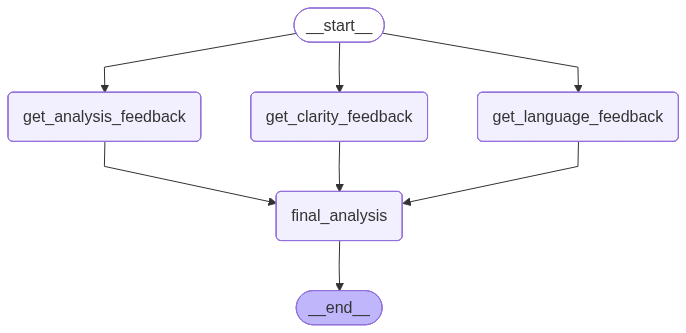

In [13]:
graph = StateGraph(UpscState)

graph.add_node('get_language_feedback', get_language_feedback)
graph.add_node('get_clarity_feedback', get_clarity_feedback)
graph.add_node('get_analysis_feedback', get_analysis_feedback)
graph.add_node('final_analysis', get_final_analysis)

# add edges
graph.add_edge(START, 'get_language_feedback')
graph.add_edge(START, 'get_clarity_feedback')
graph.add_edge(START, 'get_analysis_feedback')
graph.add_edge('get_language_feedback', 'final_analysis')
graph.add_edge('get_clarity_feedback', 'final_analysis')
graph.add_edge('get_analysis_feedback', 'final_analysis')
graph.add_edge('final_analysis', END)

app = graph.compile()
app

In [14]:
essay = """Terrorism has cast a long and dark shadow over India's post-independence history, inflicting deep wounds on its people, its economy, and its social fabric. From the hinterlands of the Northeast to the bustling metropolis of Mumbai, the specter of extremist violence has manifested in myriad forms, fueled by a complex interplay of political, religious, and socio-economic grievances. This essay delves into the multifaceted nature of terrorism in India, its devastating impact on the populace and the economy, and explores a multi-pronged approach required to counter this persistent threat.

The Human Cost and Societal Impact
The most immediate and tragic consequence of terrorism is the loss of innocent lives. The countless families shattered by bomb blasts, indiscriminate shootings, and targeted assassinations bear the deepest scars of this menace. The psychological trauma inflicted on survivors and the wider community is profound and enduring. Fear becomes a pervasive element of daily life, eroding the sense of security and freedom that is the bedrock of any civilized society. The constant threat of violence can lead to heightened anxiety, depression, and post-traumatic stress disorder, affecting the mental well-being of entire generations.



Beyond the individual and familial suffering, terrorism rends the social fabric of the nation. It often seeks to exploit and exacerbate existing communal tensions, pitting one community against another and undermining the secular ethos of the country. The exodus of Kashmiri Pandits from the Kashmir Valley stands as a stark reminder of how terrorism can engineer demographic shifts and create deep-seated mistrust. Furthermore, the targeting of religious sites and public gatherings is a calculated strategy to provoke retaliatory violence and plunge society into a cycle of hatred and bloodshed.


The Economic Fallout: A Drain on Development
The economic ramifications of terrorism are equally severe and far-reaching. Each act of terror incurs direct costs in terms of damage to infrastructure, loss of property, and the immediate cessation of economic activity. The 2008 Mumbai attacks, for instance, not only resulted in a tragic loss of life but also brought the financial capital of the country to a standstill, with significant repercussions for trade and commerce.

The indirect costs, however, are often more substantial and insidious. A climate of fear and instability deters foreign investment, hinders tourism, and disrupts supply chains. Regions plagued by persistent terrorism often lag in economic development, as resources that could be channeled into education, healthcare, and infrastructure are diverted towards security and counter-terrorism measures. This creates a vicious cycle where a lack of economic opportunities can, in turn, make vulnerable youth susceptible to the rhetoric of extremist groups. Moreover, the increased expenditure on defense and intelligence, while necessary, represents a significant drain on the national exchequer, further impeding progress in other critical sectors.

A Multi-Pronged Strategy for a Lasting Solution
Addressing the complex challenge of terrorism in India requires a comprehensive and multi-dimensional strategy that goes beyond mere military and law enforcement actions. While robust security measures and intelligence gathering are crucial first lines of defense, a lasting solution must address the root causes of extremism and foster a more inclusive and resilient society.

Strengthening the Security Apparatus: India has made significant strides in bolstering its counter-terrorism capabilities, particularly since the Mumbai attacks. The establishment of the National Investigation Agency (NIA) and the strengthening of intelligence sharing mechanisms are positive steps. Continued investment in modernizing police forces, enhancing coastal security, and leveraging technology for surveillance and threat analysis is imperative.

Tackling Cross-Border Terrorism: A significant portion of terrorist activities in India has been sponsored and supported from across the border. A firm and consistent diplomatic and political stance is essential to isolate and penalize state and non-state actors who use terrorism as an instrument of state policy. International cooperation in intelligence sharing and coordinated action against terrorist networks is also critical.

Addressing Root Causes: Military and security measures alone cannot eradicate the ideologies that fuel terrorism. It is crucial to address the underlying socio-economic and political grievances that are often exploited by extremist groups. This includes ensuring equitable development, providing educational and employment opportunities for marginalized youth, and ensuring swift and fair justice. Winning the hearts and minds of the local population in conflict-ridden areas is a vital component of any successful counter-terrorism strategy.

Promoting Social Harmony and Counter-Radicalization: Fostering a culture of tolerance, inclusivity, and respect for diversity is a powerful antidote to the divisive ideologies of terrorist organizations. Educational institutions, civil society organizations, and religious leaders have a crucial role to play in promoting inter-faith dialogue and countering extremist propaganda. Effective de-radicalization programs for misguided youth can also help in bringing them back into the societal mainstream.

In conclusion, terrorism remains a formidable challenge for India, one that has tested its resilience and resolve time and again. While the nation has demonstrated remarkable strength in the face of adversity, the path to a lasting peace requires a sustained and concerted effort on multiple fronts. By combining a robust security response with a proactive approach to addressing the root causes of extremism and fostering a more inclusive and harmonious society, India can hope to overcome this scourge and secure a peaceful and prosperous future for all its citizens."""

In [ ]:
res = app.invoke({'essay':essay})
print(res.overall_feedback)